# MNIST Adversarial Images with TensorFlow

Create adversarial images to fool a MNIST classifier in TensorFlow

## A Tech Challenge & Benchmark

**Backstory**

The original concept of this notebook was based on a Machine Learning (intern) candidate tech challenge from the Toronto startup [500px](https://500px.com).

When I first saw the posting, it was at the beginning of my 3 month career pivot into Deep Learning and I thought this challenge would be a great way for me to benchmark my progress once I get started. You can read more about my career transition journey on [Medium](https://medium.com/towards-data-science/my-3-month-deep-learning-career-pivot-af94cd8d6a31) and a revised/updated version on [LinkedIn]().

Although, I didn't follow through with providing the entire final output of the challenge, I'm quite satisfied that I've successfully completed it and consider it a demonstration of my current knowledge and capability.

Prior to starting this challenge, I completed [Fast.ai: Practical Deep Learning - Part 1](http://course.fast.ai/). Read through my blog post to see my reading material - [Deep Learning Reading List](http://jasonicarter.github.io/deep-learning-reading-list).

**The Challenge (summarized)**

Create adversarial images to fool a MNIST classifier in TensorFlow.
1. Learn how adversarial examples are created. For example, “Breaking Linear Classifiers on ImageNet” gives a good overview on the subject.
2. Install Tensorflow
3. Follow “Deep MNIST for Experts” tutorial to get the MNIST classifier running.
4. Expand the code from the previous step to generate adversarial images. Specifically, pick 10 images of digit ‘2’ which are correctly classified as ‘2’ by the trained model and modify them so the network incorrectly classifies them as 6.
5. Generate adversarial examples and save them as a single image containing a grid of 10 rows and 3 columns. The rows correspond to the selected examples of ‘2’. The columns are original image, delta and adversarial image. Provide link to the resulting image.
6. Make your code clean and readable. Add comments where needed.

## Approach

1. Read basic need-to-know about adversarial images
2. Get data to be used throughout notebook
3. Build a simple CNN (test model)
4. Train it on MNIST 
5. Show model classification of 10 handwritten 2s
6. Create adversarial image to classify 2s as 6s
7. Test adversarial image with original model (in step 2)

## Data

In [319]:
# Dependencies for entire notebook here

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets
import tensorflow.keras.optimizers as optim
from mpl_toolkits.axes_grid1 import ImageGrid

In [320]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [321]:
model = keras.Sequential(
    [
        layers.Conv2D(32,(5,5),padding='SAME',activation='relu',input_shape=(28,28,1)),
        layers.MaxPooling2D(padding='SAME'),
        layers.Conv2D(64,(5,5),padding='SAME',activation='relu'),
        layers.MaxPooling2D(padding='SAME'),
        layers.Flatten(),
        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10,activation='softmax')
    ]

)
model.summary()
model.compile(optimizer=optim.SGD(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 3136)              0         
                                                                 
 dense_68 (Dense)            (None, 1024)            

In [322]:
trainedmodel = model.fit(train_images,train_labels,batch_size=100,epochs=10)

Epoch 2/10
600/600 [==============================] - 102s 169ms/step - loss: 0.7422 - accuracy: 0.7990
Epoch 3/10
600/600 [==============================] - 101s 169ms/step - loss: 0.5506 - accuracy: 0.8439
Epoch 4/10
600/600 [==============================] - 102s 169ms/step - loss: 0.4527 - accuracy: 0.8687
Epoch 5/10
600/600 [==============================] - 101s 169ms/step - loss: 0.3874 - accuracy: 0.8863
Epoch 6/10
600/600 [==============================] - 101s 169ms/step - loss: 0.3471 - accuracy: 0.8978
Epoch 7/10
600/600 [==============================] - 102s 170ms/step - loss: 0.3115 - accuracy: 0.9057
Epoch 8/10
600/600 [==============================] - 103s 172ms/step - loss: 0.2873 - accuracy: 0.9146
Epoch 9/10
600/600 [==============================] - 102s 170ms/step - loss: 0.2709 - accuracy: 0.9200
Epoch 10/10
600/600 [==============================] - 102s 169ms/step - loss: 0.2567 - accuracy: 0.9232


In [323]:
score = model.evaluate(test_images, test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.1128 - accuracy: 0.9645
Test loss: 0.11279468983411789
Test accuracy: 0.9645000100135803


In [316]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(x_image, y_label,modelG,model, lr=0.1, n_steps=1):
    # Instantiate an optimizer.
    optimizer = keras.optimizers.SGD(learning_rate=1e-3)
    # Instantiate a loss function.
    loss_fn = keras.losses.SparseCategoricalCrossentropy()
    images = []
    for _ in range(n_steps):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            fake = modelG(x_image, training=True)  # Logits for this minibatch
            fake = tf.reshape(fake,(1,28,28,1))
            fakeadded = x_image.reshape((1,28,28,1)) + fake
            images.append((x_image.reshape((28,28)),fake.numpy().reshape((28,28)),fakeadded.numpy().reshape((28,28))))
            logits = model(fakeadded)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_label, logits)
            print(logits)
            print("loss:",loss_value.numpy())
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, modelG.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, modelG.trainable_weights))

    return images

In [317]:
# Pick a random 4 image from first 1000 images 
# Create adversarial image and with target label 9
index_of_4s = np.where(test_labels == 4)[0]
rand_index = np.random.randint(0, len(index_of_4s))
image_norm = test_images[index_of_4s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = 9 

In [318]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(784, name="output")(x1)
modelG = keras.Model(inputs=inputs, outputs=outputs)

In [314]:
# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
images = create_plot_adversarial_images(image_norm, label_adv,modelG,model, lr=0.2, n_steps=20)

tf.Tensor(
[[[[ 3.97514381e+01]
   [-3.68880386e+01]
   [-1.70808792e+00]
   [ 6.65756607e+00]
   [ 2.99831772e+01]
   [ 3.15616493e+01]
   [-1.63121262e+01]
   [-2.78617802e+01]
   [ 5.40711212e+00]
   [-2.66433411e+01]
   [-5.08157272e+01]
   [-4.89775543e+01]
   [ 3.54557037e-02]
   [ 2.11888008e+01]
   [ 1.22910004e+01]
   [ 1.80310822e+01]
   [ 5.22569466e+00]
   [ 3.09046936e+00]
   [-3.28029251e+00]
   [-1.96182365e+01]
   [ 5.20300751e+01]
   [ 2.24156933e+01]
   [ 2.49703407e+01]
   [-4.49032860e+01]
   [-1.41750650e+01]
   [ 3.47338409e+01]
   [-3.58696251e+01]
   [ 6.73633957e+00]]

  [[ 3.10792065e+01]
   [-4.87331581e+00]
   [-4.00638161e+01]
   [ 5.81945953e+01]
   [-3.28059692e+01]
   [-1.74173775e+01]
   [ 4.27275658e+01]
   [ 5.79010048e+01]
   [ 3.18276081e+01]
   [-3.01233864e+01]
   [ 1.10964441e+00]
   [-3.41919022e+01]
   [ 9.83001947e-01]
   [ 8.39830399e-01]
   [-4.20690155e+00]
   [ 4.44379711e+00]
   [-2.26299496e+01]
   [-2.09351215e+01]
   [ 2.87760429e+01]


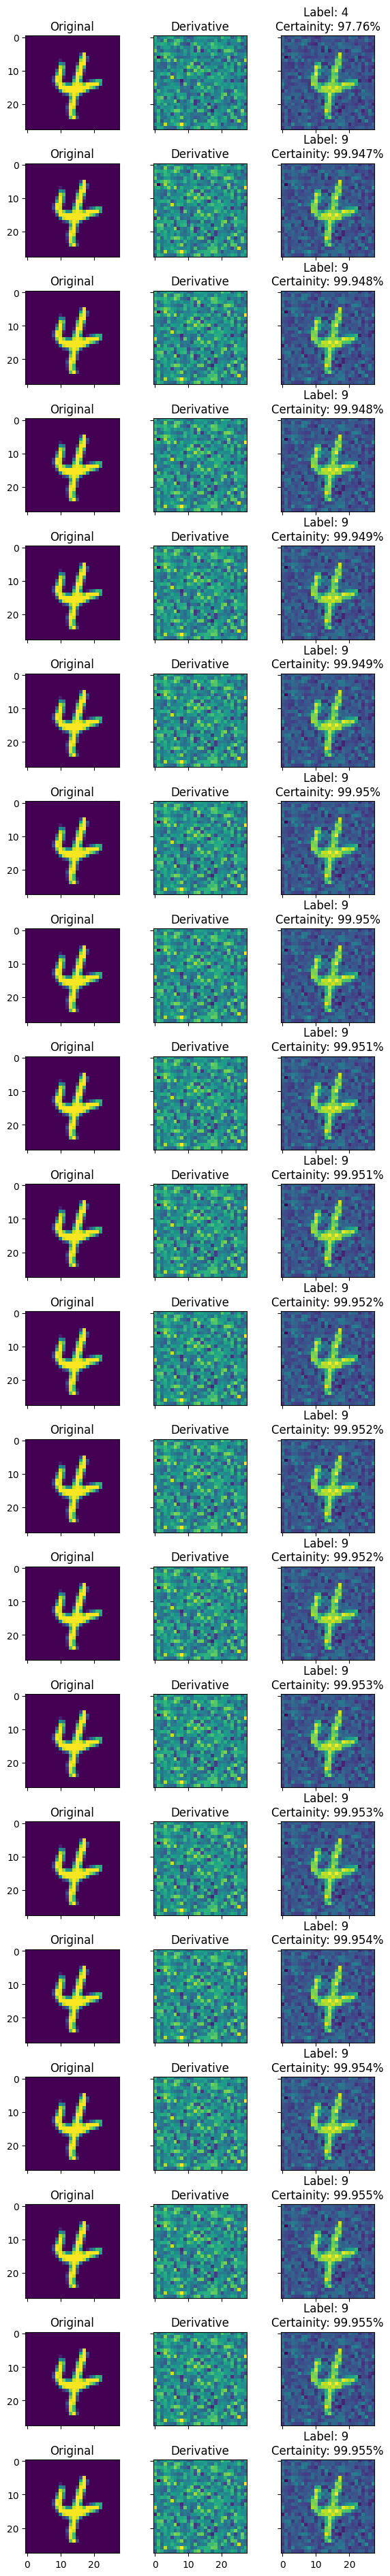

In [315]:


fig = plt.figure(figsize=(48,48))
grid = ImageGrid(fig, 111, (len(images), 3), axes_pad=0.5)
i = 0
for (image,deriv,fake) in images:
    predict = model(fake.reshape(1,28,28,1))
    predicted = np.argmax(predict)
    certainity = np.max(predict) * 100
    #print(image)
    grid[i].imshow(image)
    grid[i+1].imshow(deriv)
    grid[i+2].imshow(fake)
    grid[i].set_title('Original')
    grid[i+1].set_title('Derivative')
    grid[i+2].set_title('Label: {0} \nCertainity: {1}%' .format(predicted, round(certainity,3)))
    i += 3

plt.show